In [13]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from scipy.stats import norm

def generate_inventory_data(
    num_days=365,
    num_stores=10,
    num_brands=10,
    num_vendors=10,
    num_items=50,
    stockout_prone_fraction=0.2, # The fraction of items prone to stockout.
    late_order_fraction=0.2, # The probability that an order will be placed late but before stockout and it will arrive after stockout.
    after_stockout_order_fraction=0.1, # The probability that an order will be placed after stockout.
    avg_lead_time_per_vendor_store=None,
    initial_stock_mean=50,
    initial_stock_std_dev=25,
    reorder_level_multiplier=1.7,
    order_quantity_multiplier=1.5
):
    start_date = pd.Timestamp('2024-11-18')
    dates = pd.date_range(start=start_date, periods=num_days, freq='D')
    items = [f'ITEM_{i+1:04d}' for i in range(num_items)]
    lead_time_stockout_count = 0
    after_purchase_stockout_count = 0

    purchase_price={item: np.random.uniform(10,100) for item in items}

    # Profit margins for individual items are fixed and fall within the 20% to 50% range
    sales_price={item: purchase_price[item] * (1 + np.random.uniform(0.2,0.5)) for item in items}

    volatile_demand_items = np.random.choice(items, size=int(num_items * 0.2), replace=False)
    demand_mean_per_item={f'ITEM_{i+1:04d}': np.random.uniform(3, 10) for i in range(num_items)}
    demand_std_dev_per_item={
          f'ITEM_{i+1:04d}': demand_mean_per_item[f'ITEM_{i+1:04d}']*np.random.uniform(0.1,0.4)
          if f'ITEM_{i+1:04d}' in volatile_demand_items
          else demand_mean_per_item[f'ITEM_{i+1:04d}']*np.random.uniform(0.8,1.2)
          for i in range(num_items)}

    stores = range(1, num_stores + 1)
    brands = range(1, num_brands + 1)
    vendors = {i + 1: f'VENDOR_{i+1:03d}' for i in range(num_vendors)}
    vendor_map = {v: k for k, v in vendors.items()}

    item_to_brand = {item: np.random.choice(brands) for item in items}
    brand_to_items = {brand: [item for item, b in item_to_brand.items() if b == brand] for brand in brands}

    count_store_iteration = {store: 0 for store in stores}
    count_brand_iteration = {brand: 0 for brand in brands}
    temp_store_group = list(stores)
    temp_brand_group = list(brands)
    vendor_supply = {vendor_id: {'stores': [], 'brands': []} for vendor_id in vendors}

    # Each vendor can supply only a subset of brands to a subset of stores. It is ensured that each element is part of atleast one subset.
    for vendor_id in vendors:
        store_group = list(np.random.choice(temp_store_group, size=np.random.randint(int(0.2*num_stores), int(0.4*num_stores + 1)), replace=False))
        brand_group = list(np.random.choice(temp_brand_group, size=np.random.randint(int(0.2*num_brands), int(0.4*num_brands + 1)), replace=False))
        for store in store_group:
            count_store_iteration[store] += 1
            if count_store_iteration[store] >= int(0.4*num_stores):
                temp_store_group.remove(store)
        for brand in brand_group:
            count_brand_iteration[brand] += 1
            if count_brand_iteration[brand] >= int(0.4*num_brands):
                temp_brand_group.remove(brand)
        vendor_supply[vendor_id]['stores'] = store_group
        vendor_supply[vendor_id]['brands'] = brand_group

    # Lead time for every vendor-store combination is different, ranging from 2 to 7 days
    if avg_lead_time_per_vendor_store is None:
        avg_lead_time_per_vendor_store = {
            vendor_name: {store: np.random.randint(2, 8) for store in vendor_supply[vendor_id]['stores']}
            for vendor_id, vendor_name in vendors.items()
        }
    # Most vendor-store deliveries are reliable, but a select few are highly unpredictable.
    unreliable_vendors = np.random.choice(list(vendors.values()), size=int(num_vendors * 0.2), replace=False)

    # Vendor inconsistency is simulated through higher coefficient of variation of lead time.
    lead_time_std_dev_per_vendor_store = {
        vendor_name: {
            store: avg_lead_time_per_vendor_store[vendor_name][store] * np.random.uniform(0.1, 0.3)
            if vendor_name not in unreliable_vendors
            else
            avg_lead_time_per_vendor_store[vendor_name][store] * np.random.uniform(0.7, 1.0)
            for store in avg_lead_time_per_vendor_store[vendor_name]
        }
        for vendor_name in avg_lead_time_per_vendor_store
    }

    # List of items each store possesses.
    store_item_map = {store: set() for store in stores}
    for vendor_id in vendors:
        for store in vendor_supply[vendor_id]['stores']:
            for brand in vendor_supply[vendor_id]['brands']:
                store_item_map[store].update(brand_to_items[brand])

    item_store_map = {item: set() for item in items}
    for store in store_item_map:
        for item in store_item_map[store]:
            item_store_map[item].add(store)

    del store_item_map, count_store_iteration, count_brand_iteration, temp_store_group, temp_brand_group

    # Some stores experience more stockouts
    num_stockout_prone = int(num_stores * stockout_prone_fraction)
    stockout_prone_stores = np.random.choice(stores, num_stockout_prone, replace=False)

    # Inventory_begin_data conatins the invetory levels of each item-store combination at the beginning of the available date range
    inventory_begin_data = [{'InventoryID': f'{item}_{store}', 'Item': item, 'Store': store,
                             'Brand': item_to_brand[item], 'Onhand': int(max(0,np.random.normal(initial_stock_mean, initial_stock_std_dev))),
                             'Price': round(purchase_price[item], 0), 'StartDate': start_date} for item in items for store in item_store_map[item]]

    inventory_begin_df = pd.DataFrame(inventory_begin_data)

    # inventory contains inventory level on the current date
    inventory = inventory_begin_df.set_index(['Item','Store'])['Onhand'].to_dict()
    purchases = []
    sales = []

    # daily_inventory stores the daily inventory levels.
    daily_inventory = {(item, store): {start_date: inventory[(item, store)]} for item in items for store in item_store_map[item]}

    vendor_lead_times = {vendor: [] for vendor in vendors.values()}

    # late_order_count stores the number of times an item in a store has been ordered before stockout but it arrived after stockout.
    late_order_count = {(item, store): 0 for item in items for store in stores}

    # after_stockout_count stores the number of times an item in a store has been ordered after stockout.
    after_stockout_count = {(item, store): 0 for item in items for store in stores}

    # Stores the reorder value calculated each time for every combination of item, store and vendor.
    reorder_dict = {(item, store, vendor): 0 for item in items for store in stores for vendor in vendors.values()}

    for date in dates:
        daily_sales = []
        for item in items:
            current_stores = item_store_map[item]
            for current_store in current_stores:
                demand = max(0, int(np.random.normal(demand_mean_per_item[item], demand_std_dev_per_item[item])))
                sold_quantity = min(inventory[(item, current_store)], demand)
                inventory[(item, current_store)] -= sold_quantity

                if sold_quantity > 0:
                    daily_sales.append({'InventoryID': f'{item}_{current_store}', 'Item': item, 'Store': current_store, 'Brand': item_to_brand[item],
                                        'SalesQuantity': sold_quantity, 'SalesPrice': round(sales_price[item], 0), 'SalesTotal':round(sales_price[item]*sold_quantity, 0),
                                        'SalesDate': date})

                # Update late_order_count if current stocklevel is zero and an order has already been placed
                if (inventory[(item, current_store)] == 0) and any(p['InventoryID'] == f'{item}_{current_store}' and p['ReceivingDate'] >= date for p in purchases):
                    late_order_count[(item, current_store)] += 1

                daily_inventory[(item, current_store)][date] = inventory[(item, current_store)]

                # Select the vendors that can supply the selected item to the selected store.
                eligible_vendors = [
                        v_id for v_id, supply in vendor_supply.items()
                        if current_store in supply['stores'] and item_to_brand[item] in supply['brands']
                    ]
                vendor_name = None
                vendor_number = None
                if eligible_vendors:
                    vendor_number = np.random.choice(eligible_vendors)
                    vendor_name = vendors[vendor_number]

                    # reorder_level is the stock level at which store should place an order for replenishment.
                    reorder_level = int(avg_lead_time_per_vendor_store[vendor_name][current_store] * demand_mean_per_item[item] * reorder_level_multiplier)
                    reorder_dict[(item, current_store, vendor_name)] = reorder_level

                    # order_quantity is the quantity of an item, to be ordered.
                    order_quantity = int(avg_lead_time_per_vendor_store[vendor_name][current_store] * demand_mean_per_item[item] * order_quantity_multiplier)

                    # Check whether an order has already been placed, proceed only if no order is placed for the item.
                    if inventory[(item, current_store)] <= reorder_level and not any(p['InventoryID'] == f'{item}_{current_store}' and p['ReceivingDate'] >= date for p in purchases):

                        # If the inventory is already out-of-stock, update the after_stockout_count.
                        if inventory[(item, current_store)]==0:
                            after_stockout_count[(item, current_store)] += 1

                        lead_time_avg = avg_lead_time_per_vendor_store[vendor_name][current_store]
                        current_std_dev = lead_time_std_dev_per_vendor_store[vendor_name][current_store]
                        lead_time = max(1, int(np.random.normal(lead_time_avg, current_std_dev)))

                        # Initialize the stockout flags.
                        is_late_order = False
                        is_stockout_during_lead_time = False
                        is_stockout_before_purchase_order = False

                        # If the store is more likely to order late assign higher probability of placing an order late.
                        # But this doesnt mean that there is 80 or 60 percent chance of a late order as the final probability depends on additional conditions.
                        if current_store in stockout_prone_stores:
                            is_late_order = (np.random.rand() < 0.6)
                        else:
                            is_late_order = (np.random.rand() < 0.4)

                        # Stockout during lead time has been given a higher chance to occur compared to stockout before purchase order.
                        if is_late_order:
                            choice = np.random.choice(['is_stockout_during_lead_time', 'is_stockout_before_purchase_order'], p=[0.7, 0.3])
                            if choice == 'is_stockout_during_lead_time':
                                is_stockout_during_lead_time = True
                                is_stockout_before_purchase_order = False
                            else:
                                is_stockout_during_lead_time = False
                                is_stockout_before_purchase_order = True

                        if is_stockout_during_lead_time:
                            lead_time_stockout_count += 1
                            # The probabilty of stockout during lead time will be highest if the lead time is centered around the mean of the time-to-stockout distribution.
                            # The value of probabilty depends on the lead time and standard deviation of time-to-stockout random variable.
                            po_date = date + pd.Timedelta(days=int(max(0,(inventory[(item, current_store)]/demand_mean_per_item[item])-0.5*lead_time)))
                        elif is_stockout_before_purchase_order:
                            after_purchase_stockout_count += 1
                            # If the po_date is set to be one standard deviation from the expected date of stockout, the probability that stockout occurs before purchase is 84%.
                            po_date = date + pd.Timedelta(days=int(max(0,(inventory[(item, current_store)]/demand_mean_per_item[item])+current_std_dev)))
                        else:
                            po_date = date

                        purchase_order = {
                            'InventoryID': f'{item}_{current_store}', 'Item': item, 'Store': current_store, 'Brand': item_to_brand[item],
                            'VendorNumber': vendor_number, 'VendorName': vendor_name, 'PONumber': np.random.randint(1000, 9999),
                            'PODate': po_date,
                            'ReceivingDate':  po_date + pd.Timedelta(days=lead_time),
                            'InvoiceDate': po_date + pd.Timedelta(days=np.random.randint(1, 5)),
                            'PayDate': po_date + pd.Timedelta(days=np.random.randint(10, 20)),
                            'PurchasePrice': round(purchase_price[item], 0), 'Quantity': order_quantity, 'PayAmount': round(purchase_price[item]*order_quantity, 0),
                        }
                        purchases.append(purchase_order)
                        vendor_lead_times[vendor_name].append((po_date, purchase_order['ReceivingDate']))

        sales.extend(daily_sales)

        # If its the day of order arrival update the inventory
        for purchase in [p for p in purchases if p['ReceivingDate'] == date]:
            inventory[(purchase['Item'], purchase['Store'])] += purchase['Quantity']
            daily_inventory[(purchase['Item'], purchase['Store'])][date] = inventory[(purchase['Item'], purchase['Store'])]

        for item, store in inventory.keys():
            inventory[(item, store)] = max(0, inventory[(item, store)])
            daily_inventory[(item, store)][date] = inventory[(item, store)]

    inventory_end_data = [{'InventoryID': f'{item}_{store}', 'Item': item, 'Store': store,
                           'Brand': item_to_brand[item], 'Onhand': inventory[(item, store)],
                           'Price': round(purchase_price[item], 0), 'EndDate': dates[-1]} for item in items for store in item_store_map[item]]

    inventory_end_df = pd.DataFrame(inventory_end_data)
    purchases_df = pd.DataFrame(purchases)
    sales_df = pd.DataFrame(sales)

    all_inventory_begin_ids = set(inventory_begin_df['InventoryID'])
    all_inventory_end_ids = set(inventory_end_df['InventoryID'])
    assert all_inventory_begin_ids == all_inventory_end_ids, "InventoryIDs mismatch between begin and end"

    print(f"Lead Time Stockout Count: {lead_time_stockout_count}")
    print(f"After Purchase Stockout Count: {after_purchase_stockout_count}")

    return inventory_begin_df, inventory_end_df, purchases_df, sales_df, reorder_dict, daily_inventory


# Generate the dataframes
inventory_begin_df, inventory_end_df, purchases_df, sales_df, reorder_dict, daily_inventory = generate_inventory_data()

print("Inventory Begin:")
print(inventory_begin_df.head())
print("\nInventory End:")
print(inventory_end_df.head())
print("\nPurchases:")
print(purchases_df.head())
print("\nSales:")
print(sales_df.head())

# To save to CSV files:
inventory_begin_df.to_csv('inventory_begin.csv', index=False)
inventory_end_df.to_csv('inventory_end.csv', index=False)
purchases_df.to_csv('purchases.csv', index=False)
sales_df.to_csv('sales.csv', index=False)

Lead Time Stockout Count: 5293
After Purchase Stockout Count: 2299
Inventory Begin:
   InventoryID       Item  Store  Brand  Onhand  Price  StartDate
0  ITEM_0001_1  ITEM_0001      1      1      33   34.0 2024-11-18
1  ITEM_0001_3  ITEM_0001      3      1      58   34.0 2024-11-18
2  ITEM_0001_4  ITEM_0001      4      1      50   34.0 2024-11-18
3  ITEM_0001_5  ITEM_0001      5      1       0   34.0 2024-11-18
4  ITEM_0001_6  ITEM_0001      6      1      28   34.0 2024-11-18

Inventory End:
   InventoryID       Item  Store  Brand  Onhand  Price    EndDate
0  ITEM_0001_1  ITEM_0001      1      1      13   34.0 2025-11-17
1  ITEM_0001_3  ITEM_0001      3      1       0   34.0 2025-11-17
2  ITEM_0001_4  ITEM_0001      4      1      21   34.0 2025-11-17
3  ITEM_0001_5  ITEM_0001      5      1      19   34.0 2025-11-17
4  ITEM_0001_6  ITEM_0001      6      1      50   34.0 2025-11-17

Purchases:
    InventoryID       Item  Store  Brand  VendorNumber  VendorName  PONumber  \
0   ITEM_0001_5 

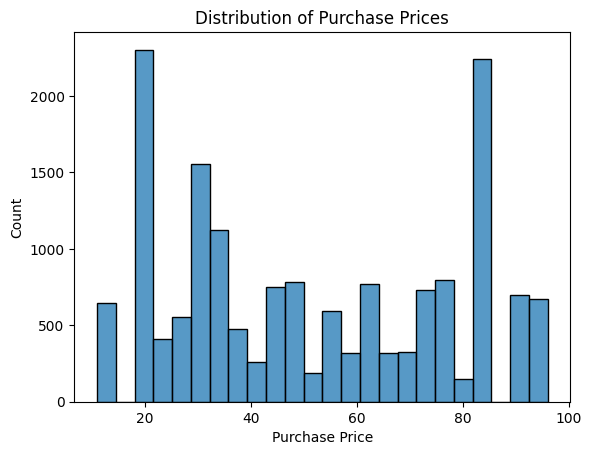

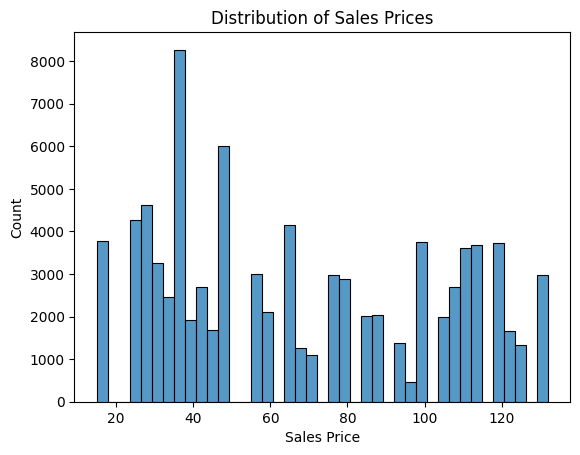

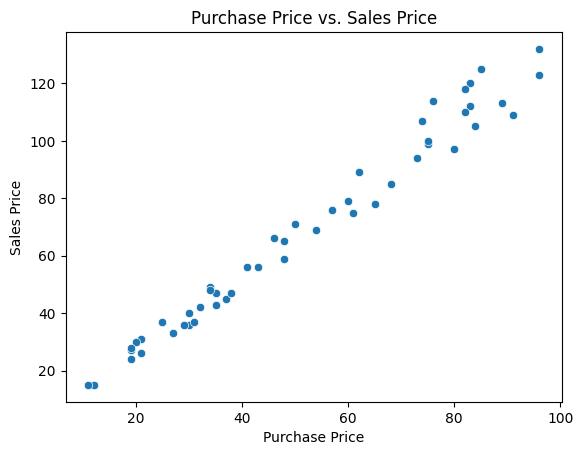

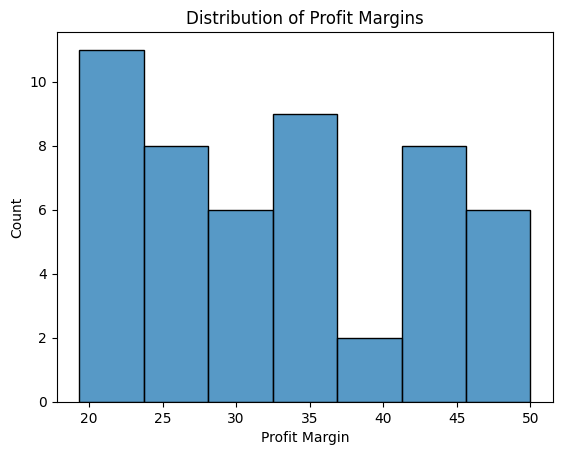

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(purchases_df['PurchasePrice'])
plt.xlabel('Purchase Price')
plt.ylabel('Count')
plt.title('Distribution of Purchase Prices')
plt.show()

sns.histplot(sales_df['SalesPrice'])
plt.xlabel('Sales Price')
plt.ylabel('Count')
plt.title('Distribution of Sales Prices')
plt.show()

df = pd.merge(purchases_df, sales_df, on='Item', how='inner')
df = df[['Item', 'PurchasePrice', 'SalesPrice']].drop_duplicates()
sns.scatterplot(data=df, x='PurchasePrice', y='SalesPrice')
plt.xlabel('Purchase Price')
plt.ylabel('Sales Price')
plt.title('Purchase Price vs. Sales Price')
plt.show()

sns.histplot((df['SalesPrice']-df['PurchasePrice'])*100/df['PurchasePrice'])
plt.xlabel('Profit Margin')
plt.ylabel('Count')
plt.title('Distribution of Profit Margins')
plt.show()

<ipython-input-15-4b280f74d277>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lead Time'] = (df['ReceivingDate'] - df['PODate']).dt.days
<ipython-input-15-4b280f74d277>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lead Time'] = (df['ReceivingDate'] - df['PODate']).dt.days
<ipython-input-15-4b280f74d277>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

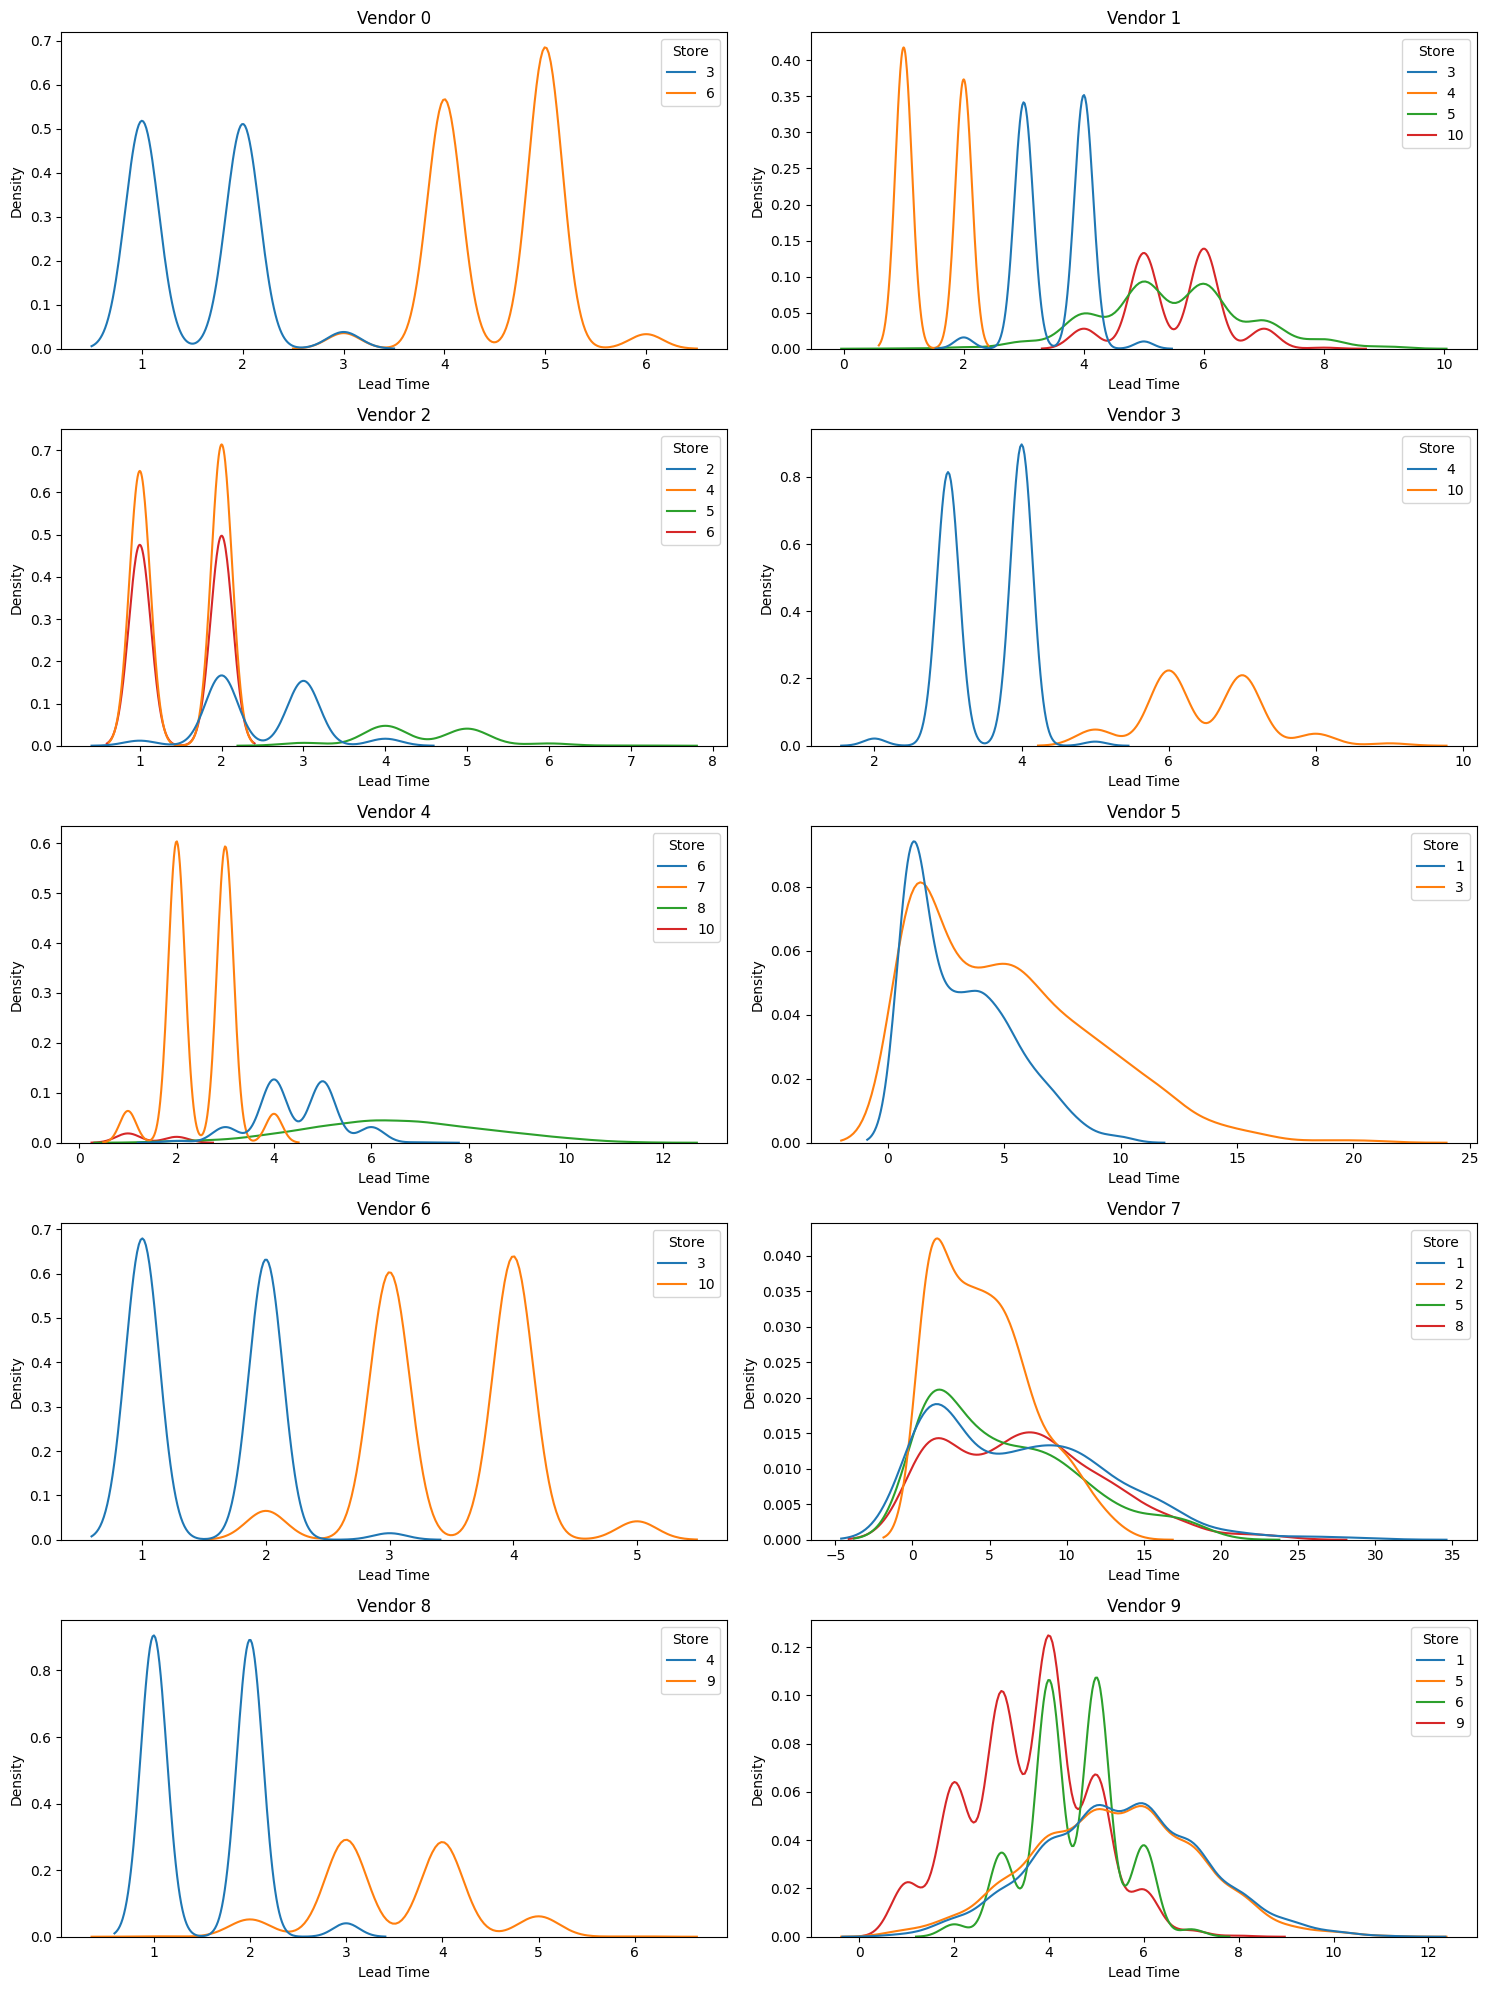

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    df = purchases_df[purchases_df['VendorNumber'] == i+1]
    df['Lead Time'] = (df['ReceivingDate'] - df['PODate']).dt.days
    sns.kdeplot(data = df, x='Lead Time', hue='Store', palette='tab10', ax=ax)
    ax.set_title(f'Vendor {i}')
plt.tight_layout()
plt.show()

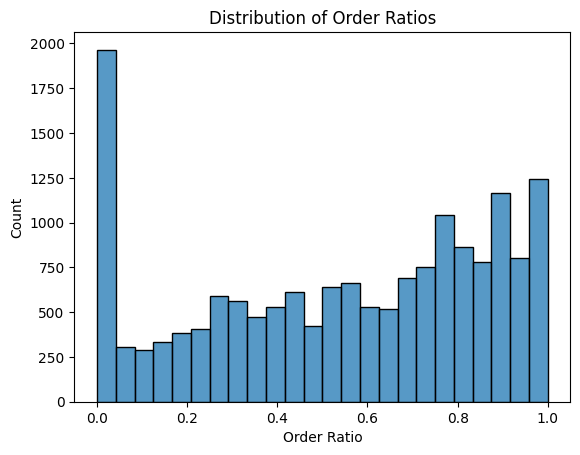

In [16]:
num_stores=10
num_vendors=10
num_items=50
items = [f'ITEM_{i+1:04d}' for i in range(num_items)]
stores = range(1, num_stores + 1)
vendors = {i + 1: f'VENDOR_{i+1:03d}' for i in range(num_vendors)}

reorder_df = pd.DataFrame([(key[0], key[1], key[2], value) for key, value in reorder_dict.items()], columns=['Item', 'Store', 'VendorName', 'ReorderLevel'])
daily_inventory_df = pd.DataFrame([(key[0], key[1], date, stock) for key, value in daily_inventory.items() for date, stock in value.items()],
                                  columns=['Item', 'Store', 'Date', 'Inventory'])

df = pd.merge(purchases_df, reorder_df, on=['Item','Store','VendorName'], how='left')
df = pd.merge(df, daily_inventory_df, left_on=['Item','Store','PODate'], right_on=['Item','Store','Date'], how='left')

df['order_ratio'] = round(df['Inventory']/df['ReorderLevel'],2)
sns.histplot(df['order_ratio'])
plt.xlabel('Order Ratio')
plt.ylabel('Count')
plt.title('Distribution of Order Ratios')
plt.show()

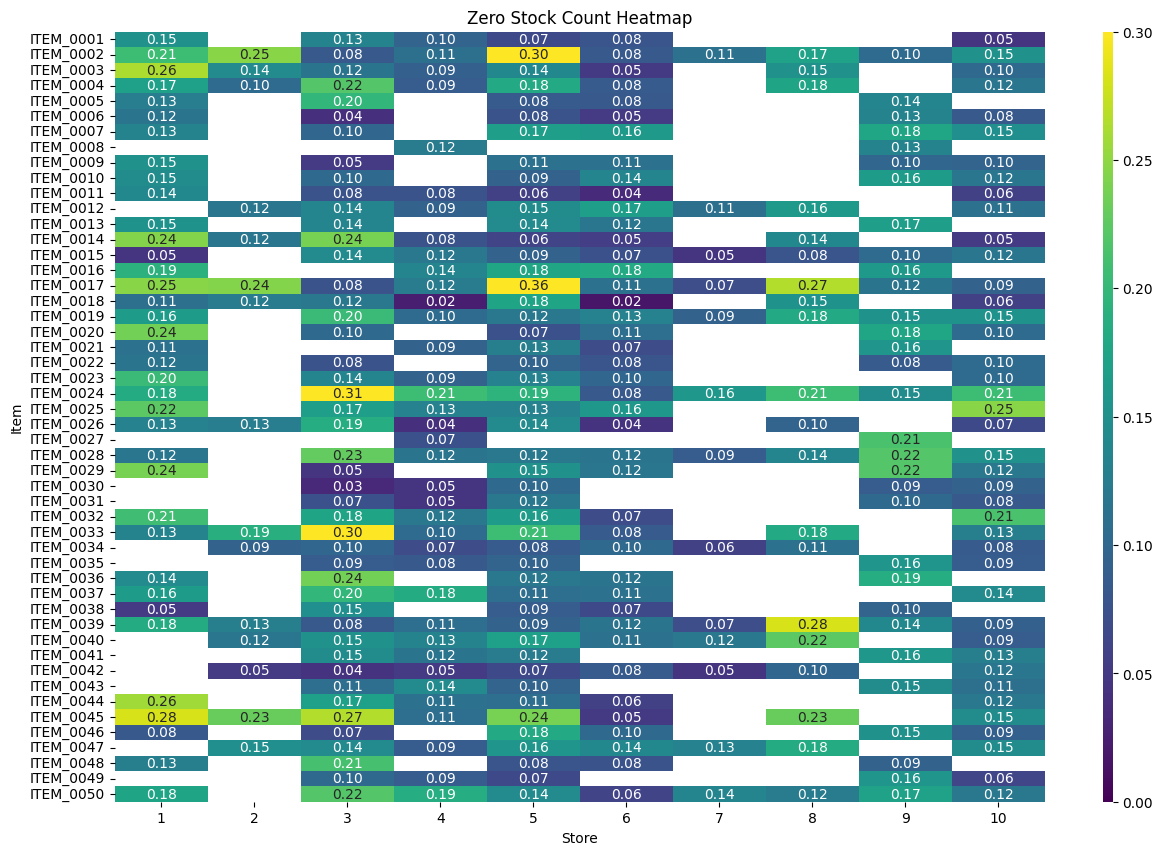

In [17]:
plt.figure(figsize=(15, 10))
zero_stock_count_df = daily_inventory_df.groupby(['Item','Store'])['Inventory'].apply(lambda x: (x == 0).sum()/len(x)).unstack()
sns.heatmap(zero_stock_count_df, cmap='viridis', annot=True, fmt=".2f", vmin=0, vmax=0.3, cbar_kws={'shrink': 1, 'aspect': 80})
plt.title('Zero Stock Count Heatmap')
plt.show()